In [1]:
%matplotlib inline

# Copy files in

In [2]:
import os
import subprocess

# Many repetitions of sounds

## Description

Classification is the process of finding patterns in data that let you distinguish one
class of datapoint from another. In this exercise, we'll start with perhaps the simplest
way of doing this: averaging across instances of a datapoint and visually inspecting
the result.

We'll use the heartbeat data described in the last section. All are sound files of heart
activity recordings. Some are *normal* heartbeat activity, while others are *abnormal*
activity. Let's see if we can spot the difference.

## Pre code

In [6]:
import subprocess
import h5io
subprocess.check_output('wget https://s3.amazonaws.com/assets.datacamp.com/production/repositories/1536/datasets/24a0da2e8c0b96df0f739ed72fd492b1a3902c22/audio_munged.hdf5'.split())
data = h5io.read_hdf5('audio_munged.hdf5')
meta = data['meta'].reset_index(drop=True)
sfreq = data['sfreq']
audio = data['data']

import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import pandas as pd
from glob import glob

normal = audio[meta.query('label == "normal"').index[:3]]
abnormal = audio[meta.query('label == "murmur"').index[:3]]

def show_plot_and_make_titles():
   axs[0, 0].set(title="Normal Heartbeats")
   axs[0, 1].set(title="Abnormal Heartbeats")
   plt.tight_layout()
   plt.show()

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Instructions

* We've loaded two DataFrames, each contains the audio for several heartbeats.
    * These are called `normal` and `abnormal`, and each has the shape `(n_times, n_audio_files)`
    * The sampling frequency is loaded into a variable called `sfreq`
* First, create the time vector for these audio files (all audio is the same length)
* Then, stack the values of the two DataFrames together so that we have a single matrix of shape (n_audio_files, n_times)
* Then, loop through each list item / axis, and:
  * Use `librosa` to load the audio file, then calculate the time vector for the file
  * Plot the audio over time in the corresponding axis object

## Hints

- The time point for each data point can be calculated by dividing by the sampling frequency.


## Solution

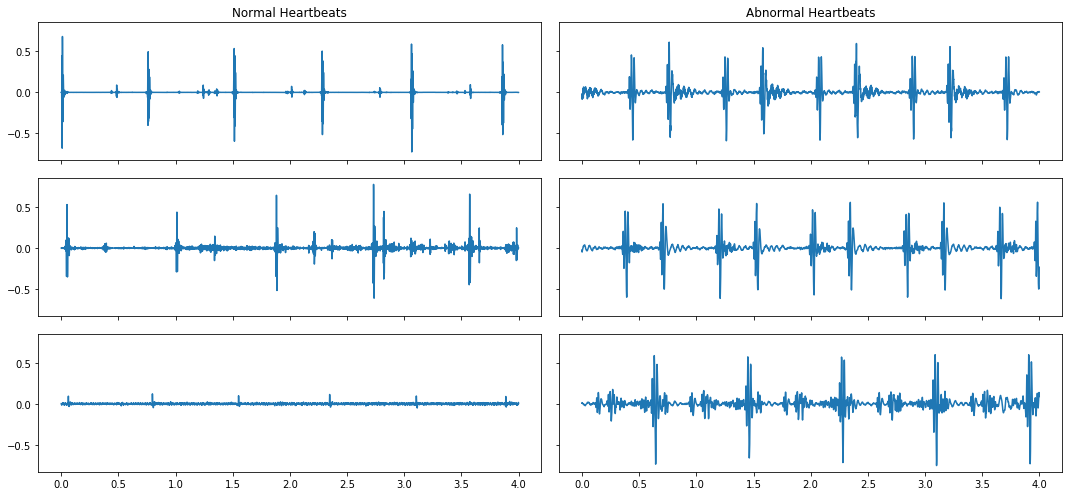

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True)

# Calculate our time vector
time = np.arange(normal.shape[0]) / sfreq

# Stack our normal/abnormal audio so we can loop and plot
stacked_audio = np.hstack([normal.values, abnormal.values]).T

# Loop through each audio file / ax object and plot
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)

show_plot_and_make_titles()

## Sample

# Invariance in time

## Description

While you should always start by visualizing your raw data, this is often uninformative when it comes to discriminating between
two classes of data points. Data is usually noisy, or exhibits complex patterns that aren't discoverable by the naked eye.

Another common technique to find simple differences between two sets of data is to *average* across multiple instances of
the same class. This *may* remove noise and reveal underlying patterns (or, it may not).

In this exercise we'll average across many instances of each class of heartbeat sound, let's see if we notice a pattern.

## Pre code

In [1]:
import subprocess
import h5io
subprocess.check_output('wget https://s3.amazonaws.com/assets.datacamp.com/production/course_6082/datasets/data.hdf5'.split())
data = h5io.read_hdf5('data.hdf5')
meta = data['meta'].reset_index(drop=True)
sfreq = data['sfreq']
audio = data['data']

import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import pandas as pd
from glob import glob

# Grab the first 5 files of each type
normal = audio[meta.query('label == "normal"').index[:10]]
abnormal = audio[meta.query('label == "murmur"').index[:10]]

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Instructions

- We have loaded two arrays (`normal` and `abnormal`) with audio data, each row is a sample of audio for that class.

  Create a time vector for the audio (we only need one since each audio sample has the same length). The sampling frequency is loaded into a variable called `sfreq`.
- Average across audio samples for each class, creating one vector per class.
- Visualize the average audio trace per class.

## Hints

- The time point for each data point can be calculated by dividing by the sampling frequency.
- In this case, the time dimension is the first dimension
- The audio amplitude should be on the y-axis, and time should be the x-axis

## Solution

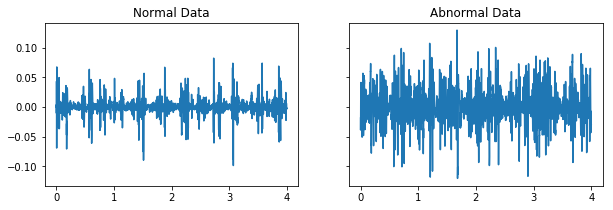

In [2]:
#' @step
# Create our time vector 
time = np.arange(normal.shape[0]) / sfreq

#' @step
# Average across the time dimension of each array
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)

#' @step
# Plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(time, mean_normal)
ax1.set(title="Normal Data")
ax2.plot(time, mean_abnormal)
ax2.set(title="Abnormal Data")
plt.show()

## Sample

# Simple word classification

## Description

While eye-balling differences is a useful way to gain an intuition for the data, let's see if we can operationalize
things with a model. In this exercise we've loaded several heartbeat sounds. Using each repetition as a
datapoint, and each moment in time as a feature, we'll fit a classifier that attempts to predict
abnormal vs. normal heartbeats using *only the raw data*.

## Pre code

In [1]:
import subprocess
import h5io
subprocess.check_output('wget https://s3.amazonaws.com/assets.datacamp.com/production/course_6082/datasets/data.hdf5'.split())
data = h5io.read_hdf5('data.hdf5')
meta = data['meta'].reset_index(drop=True)
sfreq = data['sfreq']
audio = data['data']

import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import pandas as pd
from glob import glob

normal = audio[meta.query('label == "normal"').index]
abnormal = audio[meta.query('label == "murmur"').index]

# Create our time vector 
time = np.arange(normal.shape[-1]) / sfreq

# Set up the training / testing sets
X = np.vstack([normal.T, abnormal.T])
y = np.array(['normal'] * len(normal.T) + ['abnormal'] * len(abnormal.T))
y = y.reshape([-1, 1])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=True)
y_test = y_test.squeeze()

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Instructions

- The data is loaded in the variables `X_train`, `X_test`, `y_train`, `y_test`.
- Create an instance of the `scikit-learn` model that we've imported, and fitt the model using the training data
- Use the testing data to generate predictions with the model
- Count the # of correct predictions and calculate the % of the total number of predicted classes


## Hints

- The model predictions (`predictions`) should have the same length as `y_test`

## Solution

In [2]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Initialize and fit the model
model = LinearSVC()
model.fit(X_train, y_train)

# Generate predictions and score them manually
predictions = model.predict(X_test)
percent_score = sum(predictions == y_test.squeeze()) / len(y_test)

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Sample

# Calculating the envelope of sound

## Description

One of the ways we can improve the features available to our model is to remove
some of the noise present in our data. In audio data, a common way to do this is to
_smooth_ the data and then _half-wave-rectify_ it so that the total amount of sound
energy over time is more distinguishable. We'll do this in the current exercise.

## Pre code

In [8]:
import subprocess
import h5io
subprocess.check_output('wget https://s3.amazonaws.com/assets.datacamp.com/production/repositories/1536/datasets/24a0da2e8c0b96df0f739ed72fd492b1a3902c22/audio_munged.hdf5'.split())
data = h5io.read_hdf5('audio_munged.hdf5')
meta = data['meta'].reset_index(drop=True)
sfreq = data['sfreq']
audio = data['data']

import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import pandas as pd
from glob import glob

audio = audio[0]
audio = audio.iloc[:int(1 * sfreq)]

## Instructions

- We've loaded a heartbeat file in the variable `audio`.
  
  First, visualize the raw audio we'll use to calculate the envelope.
  
- Next, half-wave rectify the audio.

  Plot the result.
  
- Finally, smooth the audio file.

  Plot the result

## Hints

- DataFrames have their own `plot` method
- Rectifying entails taking the absolute value of each datapoint
- We smooth with a `rolling` mean.

## Solution

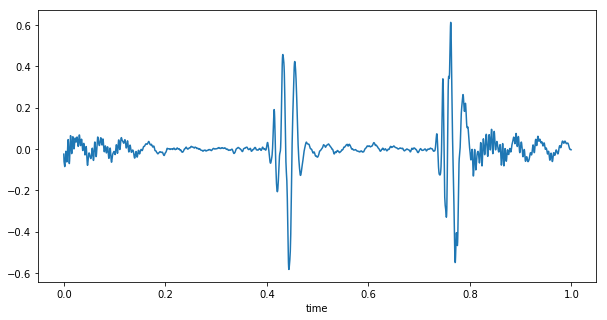

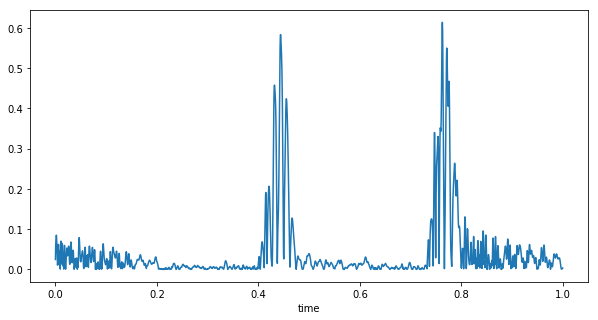

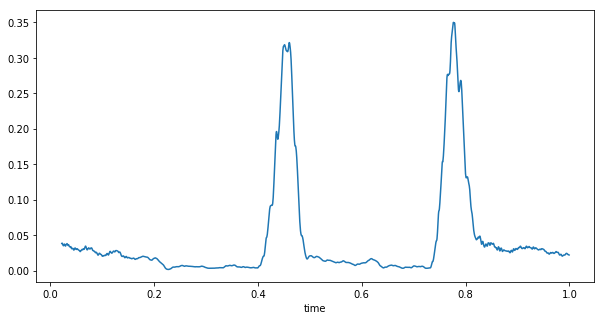

In [9]:
#' @step
# Plot the raw data first
audio.plot(figsize=(10, 5))
plt.show()

#' @step
# Rectify the audio signal
audio_half_wave = audio.apply(np.abs)

# Plot the result
audio_half_wave.plot(figsize=(10, 5))
plt.show()

#' @step
# Smooth by applying a rolling mean
audio_half_wave_smooth = audio_half_wave.rolling(50).mean()

# Plot the result
audio_half_wave_smooth.plot(figsize=(10, 5))
plt.show()

## Sample

# Calculating features from the envelope

## Description

Now that we've removed some of the noisier fluctuations in the audio, let's see if this
improves our ability to classify. We've computed the envelope of several heartbeat sounds,
they're loaded into a matrix called `audio`. It has shape `n_sounds, n_timepoints`.

## Pre code

In [3]:
import subprocess
import h5io
subprocess.check_output('wget https://s3.amazonaws.com/assets.datacamp.com/production/repositories/1536/datasets/24a0da2e8c0b96df0f739ed72fd492b1a3902c22/audio_munged.hdf5'.split())
data = h5io.read_hdf5('audio_munged.hdf5')
meta = data['meta'].reset_index(drop=True)
sfreq = data['sfreq']
audio = data['data']

import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import pandas as pd
from glob import glob

audio_half_wave = audio.apply(np.abs)
audio_half_wave_smooth = audio_half_wave.rolling(win_type='hamming', window=50).mean()
labels = meta['label'].values

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
model = LinearSVC()

## Instructions

- Calculate the mean, standard deviation, and maximum value for each heartbeat sound.
  
-  Reshape this so that it can fit into a `sklearn` classifier
  
- Now using cross validation, fit a model on each CV iteration and score it on held-out data.

## Hints

- Each statistic has its own function in numpy
- You should be stacking three 1-D vectors of the same length
- `cross_val_score` takes the model object first, then the input/output data

## Solution

In [5]:
#' @step
# Calculate the mean, standard deviation, and max of each audio sample
means = np.mean(audio, axis=0)
stds = np.std(audio, axis=0)
maxs = np.max(audio, axis=0)

#' @step
# Create our X and ymatrix
X = np.column_stack([means, stds, maxs])

y = labels.reshape([-1, 1])

#' @step
# Fit the model and score on testing data
from sklearn.model_selection import cross_val_score
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

## Sample

# Derivative features: The tempogram

## Description

One benefit of cleaning up your data is that it lets you compute more sophisticated
features. For example, the envelope calculation we performed above is a common technique
in computing **tempo** and **rhythm** features. In this exercise, we'll use `librosa`
to compute some tempo and rhythm features of our heartbeat data, and fit a model once more.

## Pre code

In [8]:
import subprocess
import h5io
subprocess.check_output('wget https://s3.amazonaws.com/assets.datacamp.com/production/repositories/1536/datasets/24a0da2e8c0b96df0f739ed72fd492b1a3902c22/audio_munged.hdf5'.split())
data = h5io.read_hdf5('audio_munged.hdf5')
meta = data['meta'].reset_index(drop=True)
sfreq = data['sfreq']
audio = data['data']

import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import pandas as pd
from glob import glob

labels = meta['label'].values

audio_half_wave = audio.apply(np.abs)
audio_half_wave_smooth = audio_half_wave.rolling(win_type='hamming', window=50).mean()

# Calculate the mean, standard deviation, and max of each audio sample
means = audio_half_wave_smooth.mean(axis=0).values
stds = audio_half_wave_smooth.std(axis=0).values
maxs = audio_half_wave_smooth.max(axis=0).values

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

model = LinearSVC()

## Instructions

- Use `librosa` to calculate a tempogram of each heartbeat audio
 
  Plot the first tempogram using `matplotlib` to confirm this was done properly
  
  Calculate the maximum, minimum, and mean of each tempogram

- Stack these features so that you can fit your classifier model
  
  Score the classifier with cross-validation

## Hints

- The tempogram is calculated with the `tempo` function, and it operates on an audio vector
- You should be column-stacking several 1-D vectors, all of the same length

## Solution

In [11]:
#' @step
# Calculate the tempo of our sounds
tempos = []
for i_audio in audio.values.T:
    tempos.append(lr.beat.tempo(i_audio, sr=sfreq, hop_length=2**6, aggregate=None))

# Convert the list to an array so we can manipulate it more easily
tempos = np.array(tempos)

# Calculate statistics of each tempo
tempos_mean = tempos.mean(axis=-1)
tempos_std = tempos.std(axis=-1)
tempos_max = tempos.max(axis=-1)

#' @step
# Create our X and y matrices with means, stds, maxs, and our tempo values
X = np.column_stack([means, stds, maxs, tempos_mean, tempos_std,tempos_max])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

## Sample

# Spectrograms of heartbeat audio

## Description

Spectral engineering is one of the most common techniques in machine learning with timeseries. The first step
in this process is to calculate a **spectrogram** of sound. This describes what spectral content (e.g., low and high pitches)
is present in the sound over time. In this example, we'll take a look at the spectrogram for a simple signal with a single
sine wave. Its frequency changes over time. We'll calculate a spectrogram of a heartbeat audio file.

## Pre code

In [7]:
import subprocess
import h5io
subprocess.check_output('wget https://s3.amazonaws.com/assets.datacamp.com/production/repositories/1536/datasets/24a0da2e8c0b96df0f739ed72fd492b1a3902c22/audio_munged.hdf5'.split())
data = h5io.read_hdf5('audio_munged.hdf5')
meta = data['meta'].reset_index(drop=True)
sfreq = data['sfreq']
audio = data['data']

import numpy as np
import matplotlib.pyplot as plt
import librosa as lr

audio = audio.values.T[0]
time = np.arange(len(audio)) / sfreq

## Instructions

- We've loaded a single heartbeat sound in the variable `audio`.
 
  Use `librosa` to calculate the spectral content (using the short-time fourier transform function) of the audio


- Now that we have our spectrogram, convert it to decibels.

  Calculate a time vector for our spectrogram and raw audio

  Visualize them as a stacked plot

## Hints

- the `spec` function is used to calculate a spectrogram
- you are calculating the decibels for the output spectrogram


## Solution

In [16]:
#' @step
# Import the functions we'll use for the STFT
from librosa.core import stft, frames_to_time, amplitude_to_db
from librosa.display import specshow

# Prepare our STFT
HOP_LENGTH = 2**4
spec = stft(audio, hop_length=HOP_LENGTH, n_fft=2**7)

#' @step
# Convert into decibels for visualization
spec_db = amplitude_to_db(spec)

# This calculates a time vector for the STFT
times_spec = frames_to_time(range(spec.shape[-1]), sfreq)

# Compare the raw audio to the spectrogram of the audio
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].plot(time, audio)
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
plt.show()

## Sample

# Engineering spectral features

## Description

As you can probably tell, there is a lot more information in a spectrogram compared to a raw audio file. By computing the
spectral features, we have a much more rich idea of what's going on. As such, there are all kinds of spectral features that
we can compute using the spectrogram as a base. In this exercise we'll look at a few of these features.

## Pre code

In [2]:
import subprocess
import h5io
subprocess.check_output('wget https://s3.amazonaws.com/assets.datacamp.com/production/repositories/1536/datasets/24a0da2e8c0b96df0f739ed72fd492b1a3902c22/audio_munged.hdf5'.split())
data = h5io.read_hdf5('audio_munged.hdf5')
meta = data['meta'].reset_index(drop=True)
sfreq = data['sfreq']
audio = data['data']

import numpy as np
import matplotlib.pyplot as plt
import librosa as lr

audio = audio.values.T[0]
time = np.arange(len(audio)) / sfreq

# Import the functions we'll use for the STFT
from librosa.core import stft, frames_to_time, amplitude_to_db
from librosa.display import specshow

# Prepare our STFT
HOP_LENGTH = 2**4
spec = np.abs(stft(audio, hop_length=HOP_LENGTH, n_fft=2**7))
times_spec = lr.core.frames_to_time(np.arange(spec.shape[-1]), hop_length=HOP_LENGTH, sr=sfreq)

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Instructions

- We've calculated the spectrogram for a sample audio file, it's in a variable called `spec`, of shape.
 
  Calculate the **spectral centroid** as well as the **spectral bandwidth** of the spectrogram.

- Convert the spectrogram to decibels for visualization
 
  Plot the spectrogram over time, as well as the spectral centroid / bandwidth.

## Hints

- The functions you'll use are called `spectral_bandwidth` and `spectral_centroid`
- Specshow takes an input spectrogram and visualizes it

## Solution

In [4]:
#' @step
# Calculate the spectral centroid and bandwidth for the spectrogram
bandwidths = lr.feature.spectral_bandwidth(S=spec)[0]
centroids = lr.feature.spectral_centroid(S=spec)[0]

#' @step
# Convert our spectrogram to decibels so we can visualize
spec_db = lr.core.amplitude_to_db(spec)

# Display these features on top of the spectrogram
fig, ax = plt.subplots(figsize=(10, 5))
ax = specshow(spec_db, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
ax.plot(times_spec, centroids)
ax.fill_between(times_spec, centroids - bandwidths / 2, centroids + bandwidths / 2, alpha=.5)
ax.set(ylim=[None, 6000])
plt.show()

## Sample

# Combining many features in a classifier

## Description

We've spent this section engineering many features from our audio data - some contain information about
how the audio changes in time, others contain information about the spectral content that is present. The
beauty of machine learning is that it can handle all of these features at the same time. If there is different
information present in each feature, it should improve the classifier's ability to distinguish our types of
audio. Note that this often requires more advanced techniques such as regularization, which we'll cover in the
next section.

For the final exercise, we've loaded many of the features that we calculated before. Combine all of them into
a matrix that can be fed into the classifier, and see how it does.

## Pre code

In [14]:
import subprocess
import h5io
subprocess.check_output('wget https://s3.amazonaws.com/assets.datacamp.com/production/repositories/1536/datasets/57f9ca59e9b30422a47eb645c40bb632f0c45669/spec_new.hdf5'.split())
data = h5io.read_hdf5('spec_new.hdf5')
spectrograms = data['data']
time = data['time']
sfreq = data['sfreq']
meta = data['meta'].reset_index(drop=True)

subprocess.check_output('wget https://s3.amazonaws.com/assets.datacamp.com/production/repositories/1536/datasets/24a0da2e8c0b96df0f739ed72fd492b1a3902c22/audio_munged.hdf5'.split())
data_audio = h5io.read_hdf5('audio_munged.hdf5')
sfreq_audio = data_audio['sfreq']
audio = data_audio['data']

import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import pandas as pd
from glob import glob

labels = meta['label'].values

audio_half_wave = audio.apply(np.abs)
audio_half_wave_smooth = audio_half_wave.rolling(win_type='hamming', window=50).mean()

# Calculate the mean, standard deviation, and max of each audio sample
means = audio_half_wave_smooth.mean(axis=0).values
stds = audio_half_wave_smooth.std(axis=0).values
maxs = audio_half_wave_smooth.max(axis=0).values

# Import the functions we'll use for the STFT
from librosa.core import stft, frames_to_time, amplitude_to_db
from librosa.display import specshow

# Prepare our STFT
HOP_LENGTH = 2**4

spectrograms = []
tempo_mean = []
tempo_std = []
tempo_max = []
for i_audio in audio.values.T:
    this_tempo = lr.beat.tempo(i_audio, sr=sfreq, hop_length=2**6, aggregate=None)
    tempo_mean.append(this_tempo.mean())
    tempo_std.append(this_tempo.std())
    tempo_max.append(this_tempo.max())
    spectrograms.append(np.abs(stft(i_audio, hop_length=HOP_LENGTH, n_fft=2**7)))
    
times_spec = lr.core.frames_to_time(np.arange(spectrograms[0].shape[-1]), hop_length=HOP_LENGTH, sr=sfreq)

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
model = LinearSVC()

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


## Instructions

- Look through each spectrogram, calculating the mean bandwidth and centroid of each

- Combine these features with previous ones we've calculated in this section
 
  Check the model's performance across multiple subsets of data

## Hints

- In the loop, use `mean` to calculate the `bandwidth` and `centroid` of each spectrogram
- You're column-stacking the newly-created vectors with several other 1-D vectors, all of the same length.

## Solution

In [16]:
#' @step
# Loop through each spectrogram
centroids = []
bandwidths = []
for spec in spectrograms:
    # Calculate the mean spectral bandwidth
    this_mean_bandwidth = np.mean(lr.feature.spectral_bandwidth(S=spec))
    
    # Calculate the mean spectral centroid
    this_mean_centroid = np.mean(lr.feature.spectral_centroid(S=spec))
    bandwidths.append(this_mean_bandwidth)  
    centroids.append(this_mean_centroid)  

#' @step
# Create our X and y matrices with means, stds, maxs, tempos, and our new values
X = np.column_stack([means, stds, maxs, tempo_mean, tempo_max, tempo_std, bandwidths, centroids])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y.squeeze(), cv=5)
print(np.mean(percent_score))

## Sample